In [19]:
import os
import ast
import pickle
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm
import numpy as np

from sklearn.pipeline import Pipeline, clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import gc
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import itertools
import pickle
import time
import gc
import logging

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score
)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [17]:
cleaned_df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'severe_outcome','gender', 'nyhac2']
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef','creat']

In [ ]:
# === Config ===
checkpoint_csv = "LR_results_checkpoint.csv"
roc_data_pickle = "LR_roc_data_checkpoint.pkl"
save_every_n_studies = 1

trial_run = False
max_test_studies = 2 if trial_run else None
max_combo_size = 2 if trial_run else None

drop_cols = ['severe_outcome', 'study', 'upid']
target_col = 'severe_outcome'

# === Logging ===
logging.basicConfig(filename='lr_brute_force.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# === Preprocessor ===
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42),
     ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']),
], remainder='passthrough')

# === Pipeline ===
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# === Hyperparameter Grid ===
logreg_param_grid = [
    {
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['l2'],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__solver': ['saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
        'clf__l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0],
    }
]

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
roc_data = {}
done_combos = set()

# === Load Data ===
all_rcts = cleaned_df['study'].unique()
if trial_run:
    all_rcts = all_rcts[:max_test_studies]

# === Main Loop ===
for test_idx, test_study in enumerate(tqdm(all_rcts, desc="Test studies")):
    best_auc = -np.inf
    best_combo = None
    best_y_test = None
    best_y_proba = None
    best_y_pred = None
    best_internal_cv_auc = None

    train_studies = [r for r in all_rcts if r != test_study]

    for k in tqdm(range(1, len(train_studies) + 1), desc=f"Train combos for {test_study}", leave=False):
        if trial_run and k > max_combo_size:
            continue

        for combo in itertools.combinations(train_studies, k):
            if (test_study, combo) in done_combos:
                continue

            train_subset = cleaned_df[cleaned_df['study'].isin(combo)]
            test_subset = cleaned_df[cleaned_df['study'] == test_study]

            X_train = train_subset.drop(columns=drop_cols)
            y_train = train_subset[target_col]
            X_test = test_subset.drop(columns=drop_cols)
            y_test = test_subset[target_col]

            if len(np.unique(y_test)) < 2:
                continue

            try:
                start_time = time.time()
                search = RandomizedSearchCV(
                    estimator=logreg_pipeline,
                    param_distributions=logreg_param_grid,
                    scoring='roc_auc',
                    refit=True,
                    cv=cv_strategy,
                    verbose=0,
                    n_jobs=-1,
                    n_iter=10,
                    random_state=42
                )

                search.fit(X_train, y_train)
                elapsed = time.time() - start_time

                best_model = search.best_estimator_
                cv_auc_mean = search.cv_results_['mean_test_score'][search.best_index_]

                y_pred = best_model.predict(X_test)
                y_proba = best_model.predict_proba(X_test)[:, 1]

                acc = accuracy_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)

                results.append({
                    'Test Study': test_study,
                    'Train Studies': combo,
                    'Num Train Studies': len(combo),
                    'Accuracy': acc,
                    'Recall': recall,
                    'Precision': precision,
                    'F1 Score': f1,
                    'ROC AUC': roc_auc,
                    'y_test': y_test.values.tolist(),
                    'y_pred': y_pred.tolist(),
                    'y_proba': y_proba.tolist(),
                    'Best Params': search.best_params_,
                    'internal_auc': cv_auc_mean
                })

                done_combos.add((test_study, combo))

                if roc_auc > best_auc:
                    best_auc = roc_auc
                    best_combo = combo
                    best_y_test = y_test.values
                    best_y_proba = y_proba
                    best_y_pred = y_pred
                    best_internal_cv_auc = cv_auc_mean

                del search, best_model
                gc.collect()

            except Exception as e:
                logging.warning(f"Failed on combo {combo} for test {test_study}: {e}")
                continue

    if best_combo is not None:
        roc_data[test_study] = {
            'y_test': best_y_test.tolist(),
            'y_proba': best_y_proba.tolist(),
            'y_pred': best_y_pred.tolist(),
            'best_combo': best_combo,
            'best_auc': best_auc,
            'internal_cv_auc': best_internal_cv_auc
        }

    # Checkpoint
    if (test_idx + 1) % save_every_n_studies == 0:
        pd.DataFrame(results).to_csv(checkpoint_csv, index=False)
        with open(roc_data_pickle, 'wb') as f:
            pickle.dump(roc_data, f)
        logging.info(f"[Checkpoint] Saved after test study: {test_study}")

# === Final Save ===
pd.DataFrame(results).to_csv("LR_results_LOSO_final.csv", index=False)
with open("LR_roc_data_final.pkl", 'wb') as f:
    pickle.dump(roc_data, f)

logging.info("✅ Final results saved successfully.")

Train combos for MDC:   0%|          | 0/8 [00:00<?, ?it/s]/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pre

In [2]:
# LOSO, best combinations, all

results_df = pd.read_csv('results df/LOSO/LR_results_LOSO_final.csv')  # if not already loaded

# Sort the DataFrame by ROC AUC in descending order
sorted_df = results_df.sort_values(by='ROC AUC', ascending=False)

# Drop duplicates to keep only the top ROC AUC row per Test Study
top_per_test_study = sorted_df.drop_duplicates(subset='Test Study', keep='first').reset_index(drop=True)

# Optional: display key columns
cols_to_show = ['Test Study', 'Train Studies', 'Accuracy', 'ROC AUC', 'F1 Score', 'internal_auc']
top_per_test_study = top_per_test_study[cols_to_show].round(3)
top_per_test_study.to_csv("results df/LR_top_per_test_study_final.csv", index=False)


# Plot ROC curves for each test study

# Example: Assume roc_data is already populated
n_studies = len(roc_data)
colors = cm.plasma(np.linspace(0, 1, n_studies))  # Use plasma colormap

plt.figure(figsize=(8, 8))

for idx, (study, data) in enumerate(roc_data.items()):
    y_test = data['y_test']
    y_proba = data['y_proba']
    
    # Ensure input is array
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    
    # Skip if only one class in y_test
    if len(np.unique(y_test)) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    train_label = ", ".join(data['best_combo'])
    
    plt.plot(
        fpr,
        tpr,
        color=colors[idx],
        label=f"{study} (AUC = {roc_auc:.2f})\nTrain: {train_label}",
        lw=2
    )

# Reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', lw=1)

# Style
plt.title("ROC Curves for Best Train-Study Combinations (LOSO), Logistic Regression", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='x-small', frameon=True)
plt.tight_layout()
#plt.savefig("graphs/model results plot/LR_roc_curves_best_loso_all_comb.png", dpi=300)
plt.show()

NameError: name 'roc_data' is not defined

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import ast
from matplotlib import cm

# Filter for LOSO with 8 training studies
loso_results_df = results_df[results_df['Num Train Studies'] == 8]

plt.figure(figsize=(8, 8))
auc_list = []

# Set up plasma colormap
n_curves = len(loso_results_df)
colors = cm.plasma(np.linspace(0, 1, n_curves))

for i, (idx, row) in enumerate(loso_results_df.iterrows()):
    test_study = row['Test Study']
    
    # Convert from string to list if stored as string
    y_test = row['y_test']
    y_proba = row['y_proba']

    if isinstance(y_test, str):
        y_test = ast.literal_eval(y_test)
    if isinstance(y_proba, str):
        y_proba = ast.literal_eval(y_proba)

    y_test = np.array(y_test)
    y_proba = np.array(y_proba)

    # Skip if y_test doesn't have both classes
    if len(np.unique(y_test)) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    auc_list.append(roc_auc)

    plt.plot(fpr, tpr, label=f"{test_study} (AUC = {roc_auc:.2f})", color=colors[i], lw=2)

# Reference "chance" line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')

# Aesthetics
plt.title('ROC Curves LOSO (Train Size = 8 RCTs), Logistic Regression', fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='small', frameon=True)
plt.tight_layout()
#plt.savefig("graphs/model results plot/LR_roc_curves_best_loso_8_train.png", dpi=300)
plt.show()

NameError: name 'results_df' is not defined


=== Training on study: MDC ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (249). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (249). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) i

 - Accuracy: 0.5798
 - ROC AUC:  0.6004
 - F1 Score: 0.5370

=== Training on study: SENIORS ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_par

 - Accuracy: 0.5887
 - ROC AUC:  0.6163
 - F1 Score: 0.5544

=== Training on study: US Carvedilol ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (821). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (822). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) i

 - Accuracy: 0.5870
 - ROC AUC:  0.6049
 - F1 Score: 0.5199

=== Training on study: ANZ ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (323). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (322). n_quantiles is set to n_samples.
  warnings.warn(
/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) i

 - Accuracy: 0.4632
 - ROC AUC:  0.5719
 - F1 Score: 0.6097

=== Training on study: CIBIS II ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_par

 - Accuracy: 0.5518
 - ROC AUC:  0.6055
 - F1 Score: 0.5850

=== Training on study: MERIT-HF ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_par

 - Accuracy: 0.5693
 - ROC AUC:  0.5976
 - F1 Score: 0.3673

=== Training on study: COPERNICUS ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_par

 - Accuracy: 0.5690
 - ROC AUC:  0.6223
 - F1 Score: 0.1561

=== Training on study: CAPRICORN ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_par

 - Accuracy: 0.4864
 - ROC AUC:  0.6095
 - F1 Score: 0.6138

=== Training on study: BEST ===


/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_par

 - Accuracy: 0.4456
 - ROC AUC:  0.5836
 - F1 Score: 0.5599

=== Summary of Reverse LOSO (Train-One, Test-All-Others) ===
  training_study  accuracy  roc_auc  f1_score  \
0            MDC     0.580    0.600     0.537   
1        SENIORS     0.589    0.616     0.554   
2  US Carvedilol     0.587    0.605     0.520   
3            ANZ     0.463    0.572     0.610   
4       CIBIS II     0.552    0.605     0.585   
5       MERIT-HF     0.569    0.598     0.367   
6     COPERNICUS     0.569    0.622     0.156   
7      CAPRICORN     0.486    0.609     0.614   
8           BEST     0.446    0.584     0.560   

                                         best_params  n_test  internal_auc  
0  {'clf__warm_start': True, 'clf__tol': 0.0001, ...   15841         0.680  
1  {'clf__warm_start': False, 'clf__tol': 0.01, '...   14486         0.643  
2  {'clf__warm_start': False, 'clf__tol': 0.01, '...   15126         0.643  
3  {'clf__warm_start': False, 'clf__tol': 0.0001,...   15750         0.522  
4 

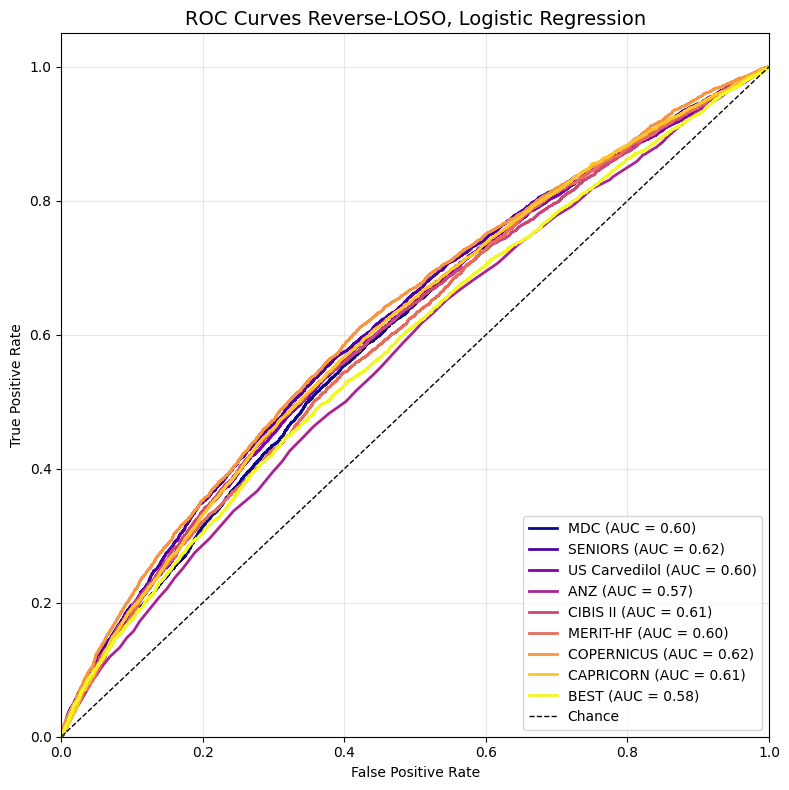

In [21]:
# Reverse the validation direction – Try training on one RCT and testing on all the others.


# === Setup ===
reverse_results = []
reverse_roc_data = {}
unique_studies = cleaned_df['study'].unique()

drop_cols = ['severe_outcome', 'study', 'upid']
target_col = 'severe_outcome'


# Define preprocessing and model
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42),
     ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']),
], remainder='passthrough')


# Preprocessor for numeric columns
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42),
     ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']),
], remainder='passthrough')

# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))  # default max_iter, will be tuned below
])

logreg_param_grid = [
    {
        'clf__penalty': ['none'],
        'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['l1'],
        'clf__solver': ['liblinear', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['l2'],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__solver': ['saga'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__max_iter': [800, 1000, 2000],
        'clf__tol': [1e-4, 1e-3, 1e-2],
        'clf__fit_intercept': [True, False],
        'clf__class_weight': [None, 'balanced'],
        'clf__warm_start': [False, True],
        'clf__l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0],
    }]
    
# === Loop over all unique RCTs ===
for training_rct in unique_studies:
    print(f"\n=== Training on study: {training_rct} ===")

    train_df = cleaned_df[cleaned_df['study'] == training_rct]
    test_df = cleaned_df[cleaned_df['study'] != training_rct]

    X_train = train_df.drop(columns=drop_cols)
    y_train = train_df['severe_outcome']
    X_test = test_df.drop(columns=drop_cols)
    y_test = test_df['severe_outcome']

    grid = RandomizedSearchCV(
        estimator=logreg_pipeline,
        param_distributions=logreg_param_grid,
        scoring='roc_auc',
        refit=True,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        verbose=0,
        n_jobs=-1,
        n_iter=10,
        random_state=42
    )

    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    cv_auc_mean = grid.cv_results_['mean_test_score'][grid.best_index_]

    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    print(f" - Accuracy: {acc:.4f}")
    print(f" - ROC AUC:  {auc_score:.4f}")
    print(f" - F1 Score: {f1:.4f}")

    reverse_results.append({
        'training_study': training_rct,
        'accuracy': acc,
        'roc_auc': auc_score,
        'f1_score': f1,
        'best_params': grid.best_params_,
        'n_test': len(y_test),
        'internal_auc': cv_auc_mean
    })

    reverse_roc_data[training_rct] = {
        'y_test': y_test.values,
        'y_proba': y_proba
    }

# === Save and Summarize ===
reverse_df = pd.DataFrame(reverse_results)

print("\n=== Summary of Reverse LOSO (Train-One, Test-All-Others) ===")
print(reverse_df.round(3))

# === Weighted Metrics ===
weighted_auc = (reverse_df['roc_auc'] * reverse_df['n_test']).sum() / reverse_df['n_test'].sum()
weighted_acc = (reverse_df['accuracy'] * reverse_df['n_test']).sum() / reverse_df['n_test'].sum()
weighted_f1 = (reverse_df['f1_score'] * reverse_df['n_test']).sum() / reverse_df['n_test'].sum()

print(f"\nWeighted ROC AUC: {weighted_auc:.4f}")
print(f"Weighted Accuracy: {weighted_acc:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# === Plot ROC Curves ===
# Prepare colors
n_studies = len(reverse_roc_data)
colors = cm.plasma(np.linspace(0, 1, n_studies))  # Same colormap as before

# === Plot ROC Curves ===
plt.figure(figsize=(8, 8))
for i, (study, data) in enumerate(reverse_roc_data.items()):
    y_test = np.array(data['y_test'])
    y_proba = np.array(data['y_proba'])

    # Skip if y_test doesn't have both classes
    if len(np.unique(y_test)) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"{study} (AUC = {roc_auc:.2f})",
        color=colors[i],
        lw=2
    )

# Chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')

# Style
plt.title('ROC Curves Reverse-LOSO, Logistic Regression', fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/LR_roc_curves_reverse_loso.pdf", dpi=600)
plt.show()

In [42]:
print("all loso results")
top_per_test_study

all loso results


,Test Study,Train Studies,Accuracy,ROC AUC,F1 Score,internal_auc
0,MDC,"('ANZ', 'CAPRICORN')",0.436,0.692,0.553,0.599
1,US Carvedilol,"('MDC', 'MERIT-HF')",0.533,0.663,0.483,0.634
2,SENIORS,"('MDC', 'CIBIS II', 'COPERNICUS')",0.587,0.645,0.240,0.616
3,CIBIS II,"('MDC', 'SENIORS', 'US Carvedilol', 'MERIT-HF'...",0.610,0.641,0.537,0.675
4,BEST,"('MDC', 'CIBIS II', 'MERIT-HF')",0.521,0.638,0.553,0.639
5,MERIT-HF,"('MDC', 'US Carvedilol', 'COPERNICUS')",0.652,0.631,0.362,0.635
6,COPERNICUS,"('MDC', 'SENIORS', 'ANZ', 'CAPRICORN', 'BEST')",0.403,0.621,0.568,0.679
7,CAPRICORN,"('MDC', 'US Carvedilol', 'COPERNICUS')",0.555,0.604,0.076,0.635
8,ANZ,"('MDC', 'US Carvedilol')",0.524,0.582,0.360,0.642


In [43]:
print("reverese loso results")
reverse_df.round(3)

reverese loso results


,training_study,accuracy,roc_auc,f1_score,best_params,n_test,internal_auc
0,MDC,0.580,0.600,0.537,"{'clf__warm_start': True, 'clf__tol': 0.0001, ...",15841,0.680
1,SENIORS,0.588,0.616,0.554,"{'clf__warm_start': False, 'clf__tol': 0.01, '...",14486,0.643
2,US Carvedilol,0.587,0.605,0.520,"{'clf__warm_start': False, 'clf__tol': 0.01, '...",15126,0.643
3,ANZ,0.463,0.572,0.610,"{'clf__warm_start': False, 'clf__tol': 0.0001,...",15750,0.522
4,CIBIS II,0.552,0.605,0.585,"{'clf__warm_start': False, 'clf__tol': 0.01, '...",13670,0.640
5,MERIT-HF,0.569,0.598,0.367,"{'clf__warm_start': True, 'clf__tol': 0.0001, ...",12295,0.631
6,COPERNICUS,0.569,0.622,0.156,"{'clf__warm_start': True, 'clf__tol': 0.0001, ...",14046,0.620
7,CAPRICORN,0.486,0.609,0.614,"{'clf__warm_start': True, 'clf__tol': 0.0001, ...",14412,0.591
8,BEST,0.446,0.584,0.560,"{'clf__warm_start': False, 'clf__tol': 0.001, ...",13598,0.639


In [44]:
print("loso results, train on 8")
loso_results_df[cols_to_show].round(3)

loso results, train on 8


,Test Study,Train Studies,Accuracy,ROC AUC,F1 Score,internal_auc
254,MDC,"('SENIORS', 'US Carvedilol', 'ANZ', 'CIBIS II'...",0.663,0.670,0.286,0.627
509,SENIORS,"('MDC', 'US Carvedilol', 'ANZ', 'CIBIS II', 'M...",0.595,0.631,0.360,0.628
764,US Carvedilol,"('MDC', 'SENIORS', 'ANZ', 'CIBIS II', 'MERIT-H...",0.570,0.634,0.450,0.633
1019,ANZ,"('MDC', 'SENIORS', 'US Carvedilol', 'CIBIS II'...",0.491,0.539,0.286,0.632
1274,CIBIS II,"('MDC', 'SENIORS', 'US Carvedilol', 'ANZ', 'ME...",0.617,0.630,0.471,0.628
1529,MERIT-HF,"('MDC', 'SENIORS', 'US Carvedilol', 'ANZ', 'CI...",0.617,0.612,0.437,0.626
1784,COPERNICUS,"('MDC', 'SENIORS', 'US Carvedilol', 'ANZ', 'CI...",0.509,0.612,0.568,0.643
2039,CAPRICORN,"('MDC', 'SENIORS', 'US Carvedilol', 'ANZ', 'CI...",0.555,0.600,0.124,0.642
2294,BEST,"('MDC', 'SENIORS', 'US Carvedilol', 'ANZ', 'CI...",0.431,0.618,0.378,0.612


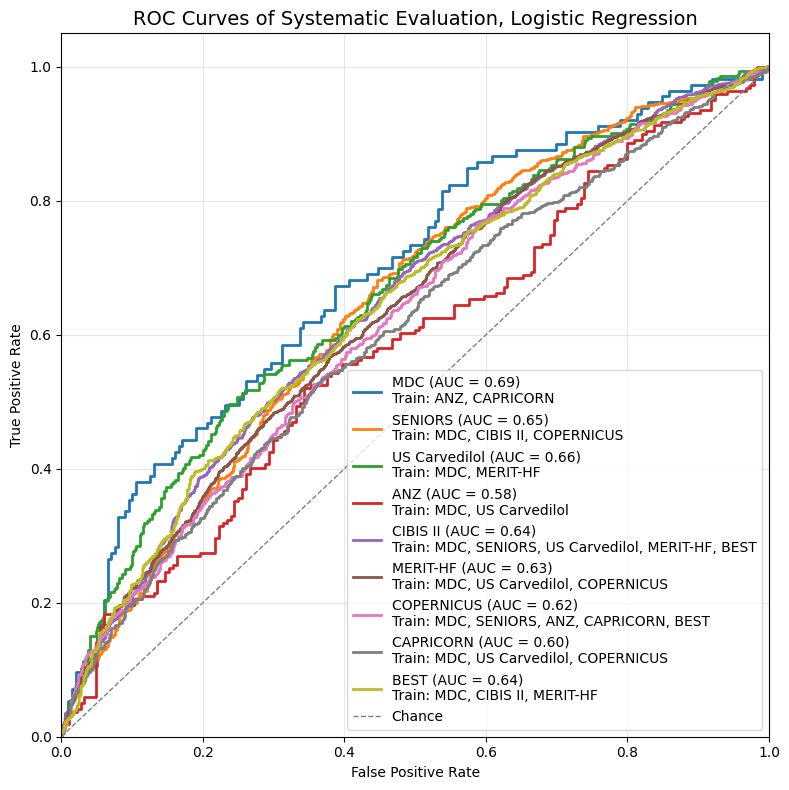

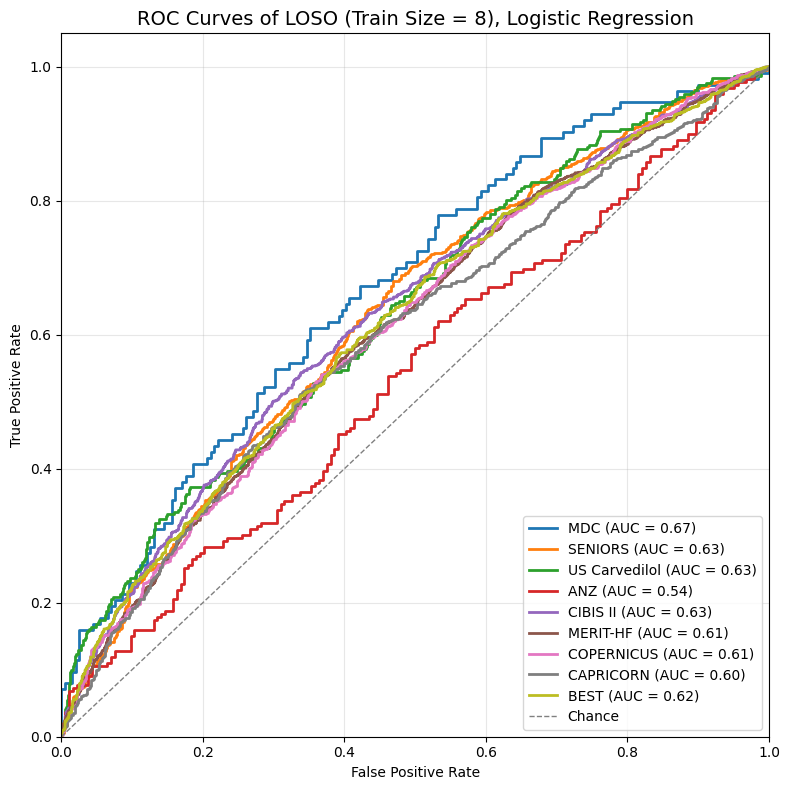

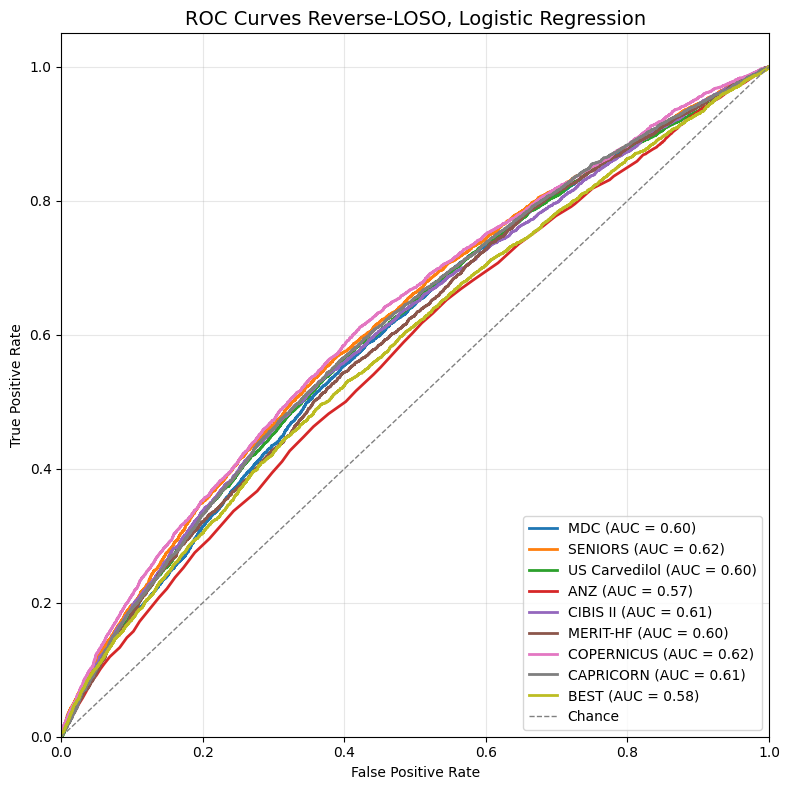

In [28]:
# plot without repeating the modeling.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import ast
from matplotlib import cm

# Custom study order used across all plots
custom_order = [
    "MDC", "SENIORS", "US Carvedilol", "ANZ", "CIBIS II",
    "MERIT-HF", "COPERNICUS", "CAPRICORN", "BEST"
]

# --- 1) Plot Best ROC Curves from summary_df (all top per test study) ---

# Load summary + full prediction results
summary_df = pd.read_csv("results df/LR_top_per_test_study_final.csv")
full_df = pd.read_csv("results df/LOSO/LR_results_LOSO_final.csv")

# Merge full predictions into summary on both 'Test Study' and 'Train Studies'
summary_df = summary_df.merge(
    full_df[['Test Study', 'Train Studies', 'y_test', 'y_proba']],
    on=['Test Study', 'Train Studies'],
    how='left'
)

best_rows = []
for test_study, group in summary_df.groupby('Test Study'):
    max_auc = -1
    best_row = None
    for _, row in group.iterrows():
        y_test = ast.literal_eval(row['y_test']) if isinstance(row['y_test'], str) else row['y_test']
        y_proba = ast.literal_eval(row['y_proba']) if isinstance(row['y_proba'], str) else row['y_proba']
        y_test = np.array(y_test)
        y_proba = np.array(y_proba)
        if len(np.unique(y_test)) < 2:
            continue
        try:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
        except Exception:
            continue
        if roc_auc > max_auc:
            max_auc = roc_auc
            best_row = row.copy()
            best_row['computed_auc'] = roc_auc
            best_row['fpr'] = fpr
            best_row['tpr'] = tpr
    if best_row is not None:
        best_rows.append(best_row)

best_rows_sorted = sorted(
    best_rows,
    key=lambda r: custom_order.index(r['Test Study']) if r['Test Study'] in custom_order else 999
)

plt.figure(figsize=(8, 8))
for row in best_rows_sorted:
    test_study = row['Test Study']
    auc_score = row['computed_auc']
    fpr = row['fpr']
    tpr = row['tpr']
    # Parse training label safely
    if isinstance(row['Train Studies'], str):
        try:
            train_label = ", ".join(ast.literal_eval(row['Train Studies']))
        except Exception:
            train_label = str(row['Train Studies'])
    else:
        train_label = str(row['Train Studies'])
    plt.plot(fpr, tpr, lw=2,
             label=f"{test_study} (AUC = {auc_score:.2f})\nTrain: {train_label}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
plt.title('ROC Curves of Systematic Evaluation, Logistic Regression', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/LR_roc_curves_best_auc_ordered.pdf", dpi=600, format='pdf')
plt.show()

# --- 2) Plot Best ROC Curves from LOSO trained on 8 studies only, no train labels ---

loso_df = full_df.copy()
# Parse Train Studies as list if string
loso_df['Train Studies'] = loso_df['Train Studies'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
loso_df = loso_df[loso_df['Train Studies'].apply(len) == 8]

best_rows = []
for test_study, group in loso_df.groupby('Test Study'):
    max_auc = -1
    best_row = None
    for _, row in group.iterrows():
        y_test = ast.literal_eval(row['y_test']) if isinstance(row['y_test'], str) else row['y_test']
        y_proba = ast.literal_eval(row['y_proba']) if isinstance(row['y_proba'], str) else row['y_proba']
        y_test = np.array(y_test)
        y_proba = np.array(y_proba)
        if len(np.unique(y_test)) < 2:
            continue
        try:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
        except Exception:
            continue
        if roc_auc > max_auc:
            max_auc = roc_auc
            best_row = row.copy()
            best_row['computed_auc'] = roc_auc
            best_row['fpr'] = fpr
            best_row['tpr'] = tpr
    if best_row is not None:
        best_rows.append(best_row)

best_rows_sorted = sorted(
    best_rows,
    key=lambda r: custom_order.index(r['Test Study']) if r['Test Study'] in custom_order else 999
)

plt.figure(figsize=(8, 8))
for row in best_rows_sorted:
    plt.plot(row['fpr'], row['tpr'], lw=2,
             label=f"{row['Test Study']} (AUC = {row['computed_auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
plt.title('ROC Curves of LOSO (Train Size = 8), Logistic Regression', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/LR_roc_curves_loso_train8_no_train_labels.pdf", dpi=600, format='pdf')
plt.show()

# --- 3) Plot Reverse LOSO ROC Curves from reverse_roc_data dictionary ---

# Ensure reverse_roc_data is defined somewhere prior in your code as a dictionary:
# reverse_roc_data = { 'MDC': {...}, 'SENIORS': {...}, ... }

ordered_items = [(study, reverse_roc_data[study]) for study in custom_order if study in reverse_roc_data]
n_studies = len(ordered_items)

plt.figure(figsize=(8, 8))
for i, (study, data) in enumerate(ordered_items):
    y_test = np.array(data['y_test'])
    y_proba = np.array(data['y_proba'])
    if len(np.unique(y_test)) < 2:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{study} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Chance')
plt.title('ROC Curves Reverse-LOSO, Logistic Regression', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize='medium', frameon=True)
plt.tight_layout()
plt.savefig("graphs/model results plot/LR_roc_curves_reverse_loso.pdf", dpi=600, format='pdf')
plt.show()
